In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
train_df = pd.read_csv('../Data/world_co2_monthly_1959-01_to_2000-12.csv')
test_df  = pd.read_csv('../Data/world_co2_monthly_2001-01_to_2013-12.csv')

In [4]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month

test_df['date'] = pd.to_datetime(test_df['date'])
test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month

In [5]:
train_df = train_df.sort_values(["year","month"]).reset_index(drop=True)
test_df  = test_df.sort_values(["year","month"]).reset_index(drop=True)

In [6]:
def add_month_cyc(df: pd.DataFrame) -> pd.DataFrame:
    """
    month(1~12)를 원형(cyclic) 특성으로 바꾸기 위해
    sin/cos 변환 컬럼을 추가한다.
    - 1월과 12월이 가깝다는 계절성 구조를 모델이 학습 가능
    """
    df = df.copy()
    rad = 2 * np.pi * df["month"] / 12
    df["month_sin"] = np.sin(rad)
    df["month_cos"] = np.cos(rad)
    return df

In [ ]:
train2 = add_month_cyc(train_df)
test2  = add_month_cyc(test_df)

,date,Value,year,month,month_sin,month_cos
0,1959-01-01,315.58,1959,1,5.000000e-01,8.660254e-01
1,1959-02-01,316.48,1959,2,8.660254e-01,5.000000e-01
2,1959-03-01,316.65,1959,3,1.000000e+00,6.123234e-17
3,1959-04-01,317.72,1959,4,8.660254e-01,-5.000000e-01
4,1959-05-01,318.29,1959,5,5.000000e-01,-8.660254e-01
...,...,...,...,...,...,...
499,2000-08-01,368.27,2000,8,-8.660254e-01,-5.000000e-01
500,2000-09-01,367.15,2000,9,-1.000000e+00,-1.836970e-16
501,2000-10-01,367.18,2000,10,-8.660254e-01,5.000000e-01
502,2000-11-01,368.53,2000,11,-5.000000e-01,8.660254e-01


In [9]:
FEATURES = ["year", "month_sin", "month_cos"]
TARGET   = "Value"

X_train = train2[FEATURES]
y_train = train2[TARGET]

X_test  = test2[FEATURES]
y_test  = test2[TARGET]

In [10]:
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [11]:
# -------------------------------
# 4) Train/Test 예측 + 점수
# -------------------------------
y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

# (Train)
train_mae  = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2   = r2_score(y_train, y_train_pred)

# (Test)
test_mae  = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2   = r2_score(y_test, y_test_pred)

print("========== [TRAIN SCORE] ==========")
print(f"TRAIN MAE  : {train_mae:.3f}")
print(f"TRAIN RMSE : {train_rmse:.3f}")
print(f"TRAIN R2   : {train_r2:.3f}")
print("===================================")

print("========== [TEST SCORE] ==========")
print(f"TEST MAE   : {test_mae:.3f}")
print(f"TEST RMSE  : {test_rmse:.3f}")
print(f"TEST R2    : {test_r2:.3f}")
print("==================================")

========== [TRAIN SCORE] ==========
TRAIN MAE  : 1.516
TRAIN RMSE : 1.871
TRAIN R2   : 0.987
========== [TEST SCORE] ==========
TEST MAE   : 7.327
TEST RMSE  : 7.847
TEST R2    : 0.021


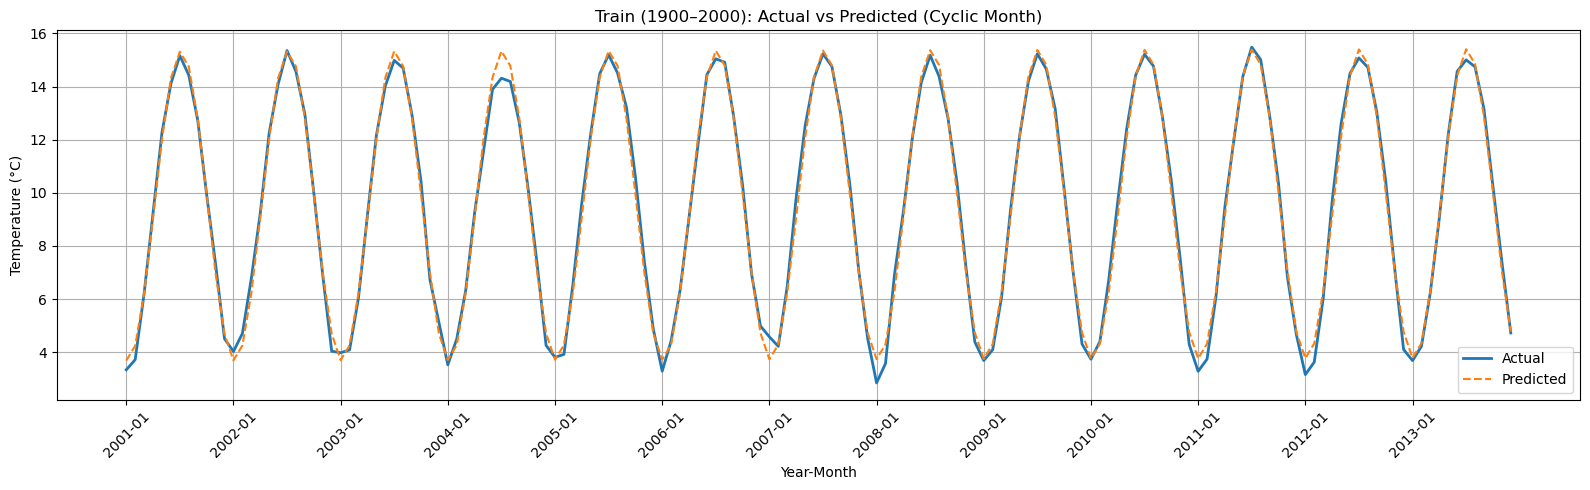

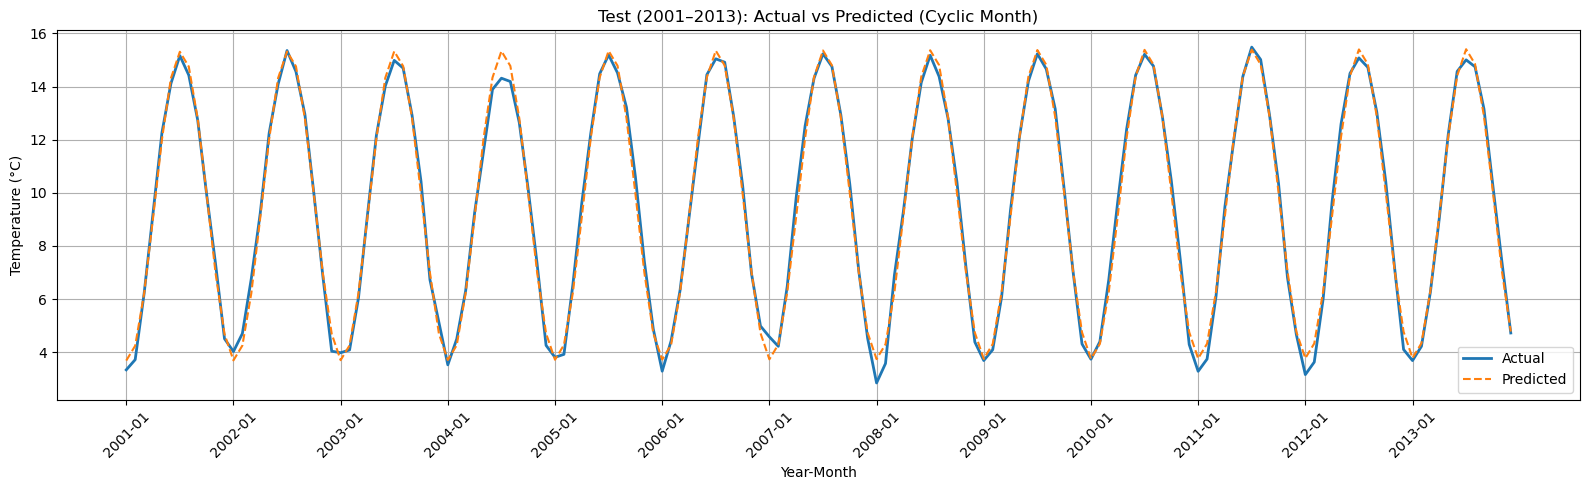

In [89]:
def plot_actual_vs_pred(df_base: pd.DataFrame, y_pred: np.ndarray, title: str):
    """
    df_base: year, month, TARGET 포함한 원본(df)
    y_pred : 예측값 (df_base 행 순서와 동일해야 함)
    """
    plot_df = df_base.copy()
    plot_df["predicted"] = y_pred

    # x축 라벨: YYYY-MM
    plot_df["ym"] = plot_df["year"].astype(str) + "-" + plot_df["month"].astype(str).str.zfill(2)

    plt.figure(figsize=(16, 5))
    plt.plot(plot_df["ym"], plot_df[TARGET], label="Actual", linewidth=2)
    plt.plot(plot_df["ym"], plot_df["predicted"], label="Predicted", linestyle="--")

    # x축 너무 많으니 1년에 한 번만 표시 (12개월 간격)
    plt.xticks(plot_df.index[::12], plot_df["ym"].iloc[::12], rotation=45)

    plt.title(title)
    plt.xlabel("Year-Month")
    plt.ylabel("Temperature (°C)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# (Train 그래프)
plot_actual_vs_pred(train_df, y_train_pred, "Train (1900–2000): Actual vs Predicted (Cyclic Month)")

# (Test 그래프)
plot_actual_vs_pred(test_df, y_test_pred, "Test (2001–2013): Actual vs Predicted (Cyclic Month)")

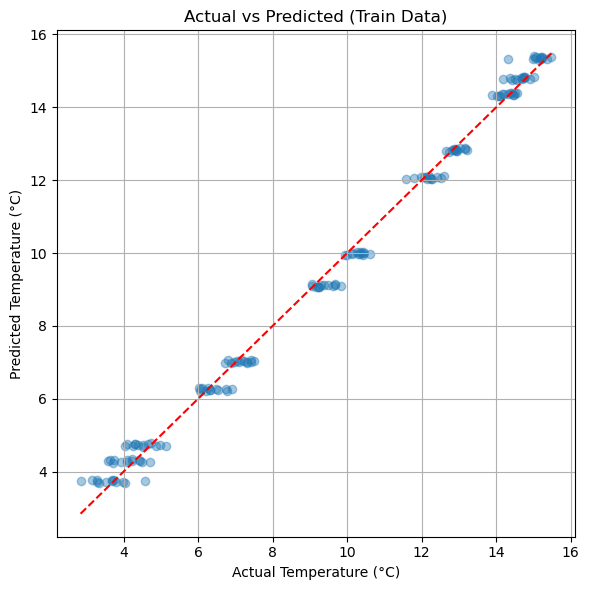

In [94]:
# train
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_train_pred, alpha=0.4)

min_val = min(y_train.min(), y_train_pred.min())
max_val = max(y_train.max(), y_train_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")

plt.title("Actual vs Predicted (Train Data)")
plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()


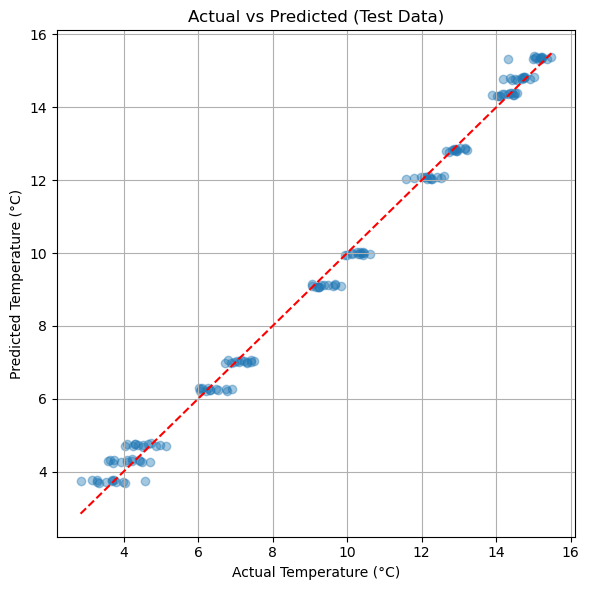

In [ ]:
# test
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.4)

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")

plt.title("Actual vs Predicted (Test Data)")
plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [92]:
def predict_year_monthly(model, year: int) -> pd.DataFrame:
    """
    입력: year(정수)
    출력: 해당 연도의 1~12월 predicted_temperature 결과 DF
    """
    future = pd.DataFrame({
        "year":  [year] * 12,
        "month": list(range(1, 13))
    })
    future2 = add_month_cyc(future)

    future["predicted_temperature"] = model.predict(future2[FEATURES])
    return future


[2014 Monthly Prediction]
    year  month  predicted_temperature
0   2014      1               3.787834
1   2014      2               4.346072
2   2014      3               6.311915
3   2014      4               9.158617
4   2014      5              12.123407
5   2014      6              14.411872
6   2014      7              15.410820
7   2014      8              14.852582
8   2014      9              12.886739
9   2014     10              10.040037
10  2014     11               7.075247
11  2014     12               4.786782


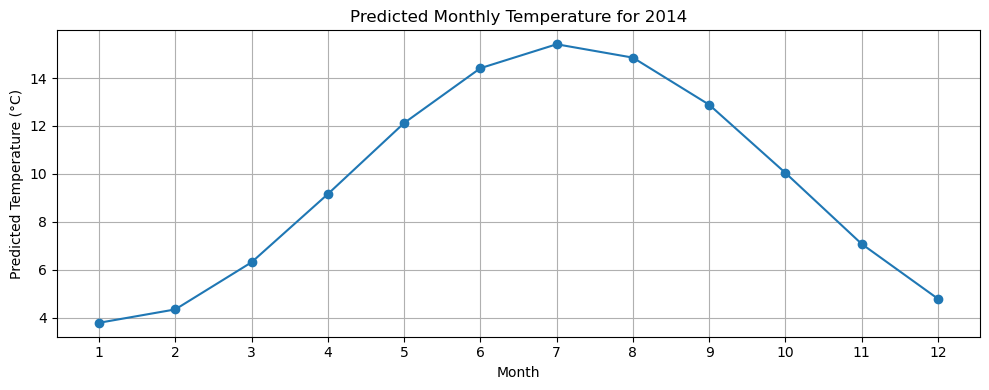

In [93]:
pred_2014 = predict_year_monthly(model, 2014)
print("\n[2014 Monthly Prediction]")
print(pred_2014)

# 2014 예측 그래프
plt.figure(figsize=(10, 4))
plt.plot(pred_2014["month"], pred_2014["predicted_temperature"], marker="o")
plt.xticks(range(1, 13))
plt.title("Predicted Monthly Temperature for 2014")
plt.xlabel("Month")
plt.ylabel("Predicted Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

==== 성능 ====
[Train] R2 : 0.9965635753750267
[Train] RMSE: 0.9690402875824436
[Test ] R2 : 0.9908857375148571
[Test ] RMSE: 0.7572049509954955
[Test ] MAE : 0.6463832483649284


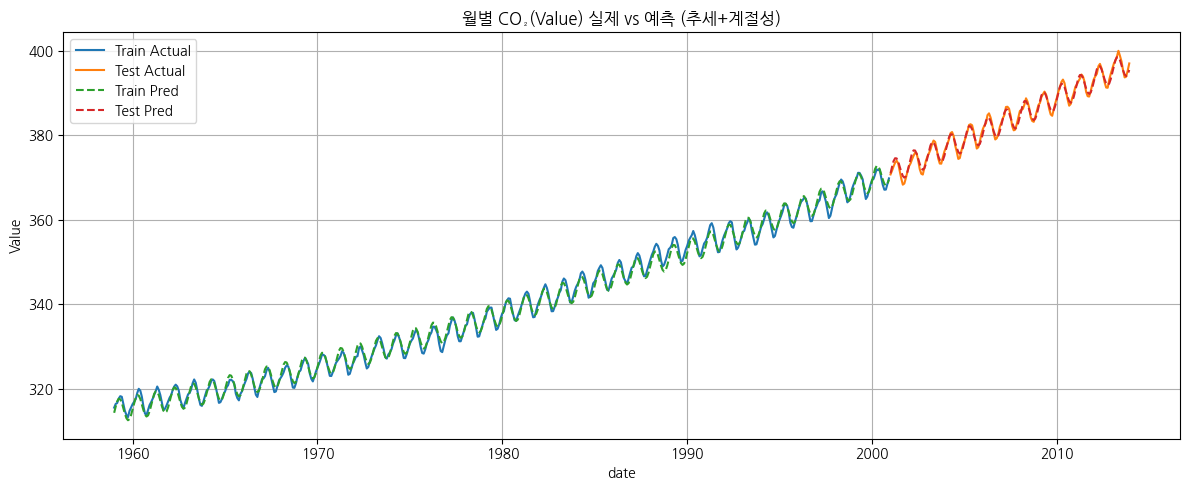

        date   Value        pred  residual
0 2001-01-01  370.76  371.018943 -0.258943
1 2001-02-01  371.69  372.601036 -0.911036
2 2001-03-01  372.63  373.895060 -1.265060
3 2001-04-01  373.55  374.595544 -1.045544
4 2001-05-01  374.03  374.556105 -0.526105


In [13]:
# ==================================================
# 월별 CO2 시계열: (1959-2000) train / (2001-2013) test
# 선형회귀로 추세(곡선) + 계절성(월) 반영해서 예측
# ==================================================
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import koreanize_matplotlib

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# 1) 데이터 로드
# -----------------------------
TRAIN_FILE = "../Data/world_co2_monthly_1959-01_to_2000-12.csv"
TEST_FILE  = "../Data/world_co2_monthly_2001-01_to_2013-12.csv"

trainDF = pd.read_csv(TRAIN_FILE)
testDF  = pd.read_csv(TEST_FILE)

# date 컬럼 datetime 변환
trainDF["date"] = pd.to_datetime(trainDF["date"])
testDF["date"]  = pd.to_datetime(testDF["date"])

# 월 단위(period)로 보려면 (원하면 사용)
trainDF["date_m"] = trainDF["date"].dt.to_period("M")
testDF["date_m"]  = testDF["date"].dt.to_period("M")

# -----------------------------
# 2) 피처 엔지니어링 (핵심)
#   - time_idx: 시간흐름(월 단위)
#   - time_idx^2: 증가가 곡선인 걸 반영(가속)
#   - month_sin/cos: 12개월 계절성 반영
# -----------------------------
def make_features(df, base_year=1959):
    df = df.copy()
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month

    # 월 단위 시간 인덱스 (1959-01이면 0)
    df["time_idx"] = (df["year"] - base_year) * 12 + (df["month"] - 1)

    # 곡선 추세용 2차항
    df["time_idx2"] = df["time_idx"] ** 2

    # 월 계절성(원형 특성) - 12개월 주기
    theta = 2 * np.pi * df["month"] / 12.0
    df["month_sin"] = np.sin(theta)
    df["month_cos"] = np.cos(theta)

    X = df[["time_idx", "time_idx2", "month_sin", "month_cos"]]
    y = df["Value"]
    return X, y, df

X_train, y_train, trainDF2 = make_features(trainDF, base_year=1959)
X_test,  y_test,  testDF2  = make_features(testDF,  base_year=1959)

# -----------------------------
# 3) 모델 학습/평가
# -----------------------------
lrModel = LinearRegression()
lrModel.fit(X_train, y_train)

pred_train = lrModel.predict(X_train)
pred_test  = lrModel.predict(X_test)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("==== 성능 ====")
print("[Train] R2 :", r2_score(y_train, pred_train))
print("[Train] RMSE:", rmse(y_train, pred_train))
print("[Test ] R2 :", r2_score(y_test, pred_test))
print("[Test ] RMSE:", rmse(y_test, pred_test))
print("[Test ] MAE :", mean_absolute_error(y_test, pred_test))

# -----------------------------
# 4) 시각화 (예측 vs 실제)
# -----------------------------
plt.figure(figsize=(12, 5))

# 실제값
plt.plot(trainDF2["date"], y_train, label="Train Actual")
plt.plot(testDF2["date"], y_test, label="Test Actual")

# 예측값
plt.plot(trainDF2["date"], pred_train, "--", label="Train Pred")
plt.plot(testDF2["date"], pred_test, "--", label="Test Pred")

plt.title("월별 CO₂(Value) 실제 vs 예측 (추세+계절성)")
plt.xlabel("date")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 5) (선택) 결과 DF로 저장
# -----------------------------
out_test = testDF2[["date", "Value"]].copy()
out_test["pred"] = pred_test
out_test["residual"] = out_test["Value"] - out_test["pred"]
print(out_test.head())


In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# =========================
# 0) 입력/출력 설정
# =========================
REAL_CSV = "../Data/world_co2_monthly_1959-01_to_2000-12.csv"
REAL_CSV2 = "../Data/world_co2_monthly_2001-01_to_2013-12.csv"

OUT_CSV = "../Data/carbon_risk_timeseries.csv"

# "Risk=100"이 되는 Value(ppm) 임계값(너가 정해야 하는 값)
# - 예: 450ppm을 임계로 두고 싶으면 450
# - 데이터 기반으로 하고 싶으면 아래에서 자동설정 옵션도 있음
THRESHOLD_VALUE = 1000.0

# 예측을 몇 개월까지 할지(무한 방지)
MAX_PRED_MONTHS = 10000  # 50년치

# =========================
# 1) 데이터 로딩 + 합치기
# =========================
df1 = pd.read_csv(REAL_CSV)
df2 = pd.read_csv(REAL_CSV2)
df = pd.concat([df1, df2], ignore_index=True)

# date 파싱
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

# (혹시 이상한 값/중복 있으면 정리)
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
df = df.dropna(subset=["Value", "date"])
df = df[df["Value"] >= 100]  # 0.xx 같은 비정상 값 제거용(너 데이터에 맞춰 조절 가능)
df = df.drop_duplicates("date", keep="first")

# =========================
# 2) 피쳐 만들기 (시간 + 계절성)
#    - 단순 year/month보다 "월별 계절성(sin/cos)" 넣는 게 예측 안정적임
# =========================
df["t"] = np.arange(len(df))  # 0,1,2,... (시간 인덱스)
df["month"] = df["date"].dt.month

# 계절성(1년 주기)
df["sin_m"] = np.sin(2*np.pi*df["month"]/12)
df["cos_m"] = np.cos(2*np.pi*df["month"]/12)

X = df[["t", "sin_m", "cos_m"]]
y = df["Value"]

# =========================
# 3) 모델 학습 (1959~2013은 전부 real로 학습)
# =========================
lr = LinearRegression()
lr.fit(X, y)

# =========================
# 4) 미래 월별 예측(Value) 생성
#    - 2014-01부터 1개월씩 추가
#    - Risk가 100 도달하면 중단
# =========================
last_date = df["date"].max()
start_pred = (last_date + pd.offsets.MonthBegin(1)).normalize()  # 다음달 1일
future_dates = []
future_values = []

cur_date = start_pred
cur_t = df["t"].iloc[-1] + 1

for _ in range(MAX_PRED_MONTHS):
    m = cur_date.month
    sin_m = np.sin(2*np.pi*m/12)
    cos_m = np.cos(2*np.pi*m/12)

    x_row = np.array([[cur_t, sin_m, cos_m]])
    pred_val = float(lr.predict(x_row)[0])

    future_dates.append(cur_date)
    future_values.append(pred_val)

    # Risk=100 도달하면 중단
    pred_risk = 100.0 * (pred_val / THRESHOLD_VALUE)
    if pred_risk >= 100.0:
        break

    # 다음 달로
    cur_date = (cur_date + pd.DateOffset(months=1)).normalize()
    cur_t += 1

future_df = pd.DataFrame({
    "date": future_dates,
    "Value": future_values
})

# =========================
# 5) Risk 스케일링 (Value → Risk)
#    - Risk = 100 * Value / THRESHOLD_VALUE
#    - 100 넘으면 100으로 캡핑(그래프용)
# =========================
def value_to_risk(v, thr=THRESHOLD_VALUE):
    r = 100.0 * (v / thr)
    return min(100.0, max(0.0, r))

# real + pred 합치기
real_out = df[["date", "Value"]].copy()
real_out["Type"] = "real"

pred_out = future_df[["date", "Value"]].copy()
pred_out["Type"] = "pred"

out = pd.concat([real_out, pred_out], ignore_index=True)

out["YearMonth"] = out["date"].dt.strftime("%Y%m").astype(int)
out["Risk"] = out["Value"].apply(value_to_risk)

# 최종 포맷
out_final = out[["YearMonth", "Risk", "Type"]].copy()
out_final["Risk"] = out_final["Risk"].round(2)

out_final.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")

print("✅ 저장 완료:", OUT_CSV)
print("✅ real 마지막:", out_final[out_final["Type"]=="real"].tail(1))
print("✅ pred 처음:", out_final[out_final["Type"]=="pred"].head(1))
print("✅ pred 마지막(임계 도달 지점):", out_final[out_final["Type"]=="pred"].tail(1))


c:\Users\KDT\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\KDT\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\KDT\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\KDT\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\KDT\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

OutOfBoundsDatetime: Cannot cast 2262-05-01 00:00:00 to unit='ns' without overflow.